In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("bank_data.csv")


In [7]:
import csv
import numpy as np
from sklearn.preprocessing import LabelEncoder
X = []
y = []

# Read data from CSV file
with open('bank_data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    next(reader)  
    for row in reader:
        features = []
        for value in row[:-1]:
            value_stripped = value.strip('"')
            try:
                features.append(int(value_stripped))
            except ValueError:
                features.append(value_stripped)
        label = row[-1].strip('"')
        # print(features)
        X.append(features)
        y.append(label)

X = np.array(X,dtype=object)
y = np.array(y,dtype=object)

# print(X[:5])

categorical_columns = [True if isinstance(val, str) else False for val in X[0]]

# Apply label encoding to categorical columns
label_encoders = []
for i, is_categorical in enumerate(categorical_columns):
    if is_categorical:
        encoder = LabelEncoder()
        X[:, i] = encoder.fit_transform(X[:, i])
        label_encoders.append(encoder)

X = X.astype(int)
# print(X)

y = encoder.fit_transform(y)
y = y.reshape(-1, 1)

# Concatenate X and y horizontally
X_y = np.hstack((X, y))

#

In [8]:
column_names = ["age","job","marital","education","default","balance","housing","loan","contact","day","month","duration","campaign","pdays","previous","poutcome","y"
]
dataFrame = pd.DataFrame(X_y,columns=column_names)

In [9]:
print(dataFrame)

      age  job  marital  education  default  balance  housing  loan  contact  \
0      30   10        1          0        0     1787        0     0        0   
1      33    7        1          1        0     4789        1     1        0   
2      35    4        2          2        0     1350        1     0        0   
3      30    4        1          2        0     1476        1     1        2   
4      59    1        1          1        0        0        1     0        2   
...   ...  ...      ...        ...      ...      ...      ...   ...      ...   
4516   33    7        1          1        0     -333        1     0        0   
4517   57    6        1          2        1    -3313        1     1        2   
4518   57    9        1          1        0      295        0     0        0   
4519   28    1        1          1        0     1137        0     0        0   
4520   44    2        2          2        0     1136        1     1        0   

      day  month  duration  campaign  p

In [16]:
import numpy
import pandas
import random

def trainTestSplit(dataFrame, testSize):
    if isinstance(testSize, float):
        testSize = round(testSize * len(dataFrame))
    indices = dataFrame.index.tolist()
    testIndices = random.sample(population = indices, k = testSize)
    dataFrameTest = dataFrame.loc[testIndices]
    dataFrameTrain = dataFrame.drop(testIndices)
    return dataFrameTrain, dataFrameTest

def checkPurity(data):
    if len(numpy.unique(data[:, -1])) == 1:
        return True
    else:
        return False

def classifyData(data):
    uniqueClasses, uniqueClassesCounts = numpy.unique(data[:, -1], return_counts = True)
    return uniqueClasses[uniqueClassesCounts.argmax()]

def getPotentialSplits(data, randomAttributes):
    potentialSplits = {}
    _, columns = data.shape
    columnsIndices = list(range(columns - 1))
    if randomAttributes != None  and len(randomAttributes) <= len(columnsIndices):
        columnsIndices = randomAttributes
    for column in columnsIndices:
        values = data[:, column]
        uniqueValues = numpy.unique(values)
        if len(uniqueValues) == 1:
            potentialSplits[column] = uniqueValues
        else:
            potentialSplits[column] = []
            for i in range(len(uniqueValues)):
                if i != 0:
                    currentValue = uniqueValues[i]
                    previousValue = uniqueValues[i - 1]
                    potentialSplits[column].append((currentValue + previousValue) / 2)
    return potentialSplits

def splitData(data, splitColumn, splitValue):
    splitColumnValues = data[:, splitColumn]
    return data[splitColumnValues <= splitValue], data[splitColumnValues > splitValue]

def calculateEntropy(data):
    _, uniqueClassesCounts = numpy.unique(data[:, -1], return_counts = True)
    probabilities = uniqueClassesCounts / uniqueClassesCounts.sum()
    return sum(probabilities * -numpy.log2(probabilities))

def calculateOverallEntropy(dataBelow, dataAbove):
    pDataBelow = len(dataBelow) / (len(dataBelow) + len(dataAbove))
    pDataAbove = len(dataAbove) / (len(dataBelow) + len(dataAbove))
    return pDataBelow * calculateEntropy(dataBelow) + pDataAbove * calculateEntropy(dataAbove)

def determineBestSplit(data, potentialSplits, randomSplits = None):
    overallEntropy = 9999
    bestSplitColumn = 0
    bestSplitValue = 0
    if randomSplits == None:
        for splitColumn in potentialSplits:
            for splitValue in potentialSplits[splitColumn]:
                dataBelow, dataAbove = splitData(data, splitColumn, splitValue)
                currentOverallEntropy = calculateOverallEntropy(dataBelow, dataAbove)
                if currentOverallEntropy <= overallEntropy:
                    overallEntropy = currentOverallEntropy
                    bestSplitColumn = splitColumn
                    bestSplitValue = splitValue
    else:
        for i in range(randomSplits):
            randomSplitColumn = random.choice(list(potentialSplits))
            randomSplitValue = random.choice(potentialSplits[randomSplitColumn])
            dataBelow, dataAbove = splitData(data, randomSplitColumn, randomSplitValue)
            currentOverallEntropy = calculateOverallEntropy(dataBelow, dataAbove)
            if currentOverallEntropy <= overallEntropy:
                overallEntropy = currentOverallEntropy
                bestSplitColumn = randomSplitColumn
                bestSplitValue = randomSplitValue
    return bestSplitColumn, bestSplitValue

def buildDecisionTree(dataFrame, currentDepth = 0, minSampleSize = 2, maxDepth = 1000, randomAttributes = None, randomSplits = None,num_nodes=0):
    if currentDepth == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = dataFrame.columns
        data = dataFrame.values
        if randomAttributes != None and randomAttributes <= len(COLUMN_HEADERS) - 1:
            randomAttributes = random.sample(population = list(range(len(COLUMN_HEADERS) - 1)), k = randomAttributes)
        else:
            randomAttributes = None
    else:
        data = dataFrame
        num_nodes = 1
    if checkPurity(data) or len(data) < minSampleSize or currentDepth == maxDepth:
        return classifyData(data),num_nodes+1

    else:
        currentDepth += 1
        potentialSplits = getPotentialSplits(data, randomAttributes)
        splitColumn, splitValue = determineBestSplit(data, potentialSplits, randomSplits)
        dataBelow, dataAbove = splitData(data, splitColumn, splitValue)
        if len(dataBelow) == 0 or len(dataAbove) == 0:
            return classifyData(data),num_nodes+1
        else:
            question = str(COLUMN_HEADERS[splitColumn]) + " <= " + str(splitValue)
            decisionSubTree = {question: []}
            yesAnswer,num_nodes_below = buildDecisionTree(dataBelow, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits,num_nodes)
            num_nodes += num_nodes_below 
            noAnswer, num_nodes_above = buildDecisionTree(dataAbove, currentDepth, minSampleSize, maxDepth, randomAttributes, randomSplits,num_nodes)
            num_nodes += num_nodes_above
            if yesAnswer == noAnswer:
                decisionSubTree = yesAnswer
            else:
                decisionSubTree[question].append(yesAnswer)
                decisionSubTree[question].append(noAnswer)
            return decisionSubTree,num_nodes

def classifySample(sample, decisionTree):
    if not isinstance(decisionTree, dict):
        return decisionTree
    question = list(decisionTree.keys())[0]
    attribute, value = question.split(" <= ")
    if sample[attribute] <= float(value):
        answer = decisionTree[question][0]
    else:
        answer = decisionTree[question][1]
    return classifySample(sample, answer)

def decisionTreePredictions(dataFrame, decisionTree):
    predictions = dataFrame.apply(classifySample, axis = 1, args = (decisionTree,))
    return predictions

def calculateAccuracy(predictedResults, category):
    resultCorrect = predictedResults == category
    return resultCorrect.mean()

In [17]:
import time
import random

dataFrameTrain, dataFrameTest = trainTestSplit(dataFrame, testSize = 0.20)

training_errors = []
validation_errors = []
num_nodes_list = []
i = 1
accuracyTrain = 0
num_nodes = 0

while accuracyTrain < 100:
    startTime = time.time()
    decisionTree,num_nodes  = buildDecisionTree(dataFrameTrain, maxDepth = i,num_nodes=num_nodes)
    buildingTime = time.time() - startTime
    decisionTreeTestResults = decisionTreePredictions(dataFrameTest, decisionTree)
    accuracyTest = calculateAccuracy(decisionTreeTestResults, dataFrameTest.iloc[:, -1]) * 100
    decisionTreeTrainResults = decisionTreePredictions(dataFrameTrain, decisionTree)
    accuracyTrain = calculateAccuracy(decisionTreeTrainResults, dataFrameTrain.iloc[:, -1]) * 100

    training_error = 100 - accuracyTrain
    training_errors.append(training_error)
    
    validation_error = 100 - accuracyTest
    validation_errors.append(validation_error)
    
    num_nodes_list.append(num_nodes)

    print("maxDepth = {}: ".format(i), end = "")
    print("accTest = {0:.2f}%, ".format(accuracyTest), end = "")
    print("accTrain = {0:.2f}%, ".format(accuracyTrain), end = "")
    print("buildTime = {0:.2f}s".format(buildingTime), end = "\n")
    i += 1

maxDepth = 1: accTest = 87.83%, accTrain = 88.64%, buildTime = 0.51s
maxDepth = 2: accTest = 87.83%, accTrain = 88.64%, buildTime = 0.88s
maxDepth = 3: accTest = 88.05%, accTrain = 89.38%, buildTime = 1.20s
maxDepth = 4: accTest = 88.94%, accTrain = 90.71%, buildTime = 1.48s
maxDepth = 5: accTest = 88.94%, accTrain = 91.18%, buildTime = 1.76s
maxDepth = 6: accTest = 88.83%, accTrain = 91.90%, buildTime = 2.19s
maxDepth = 7: accTest = 89.27%, accTrain = 92.51%, buildTime = 2.53s
maxDepth = 8: accTest = 88.38%, accTrain = 93.31%, buildTime = 2.57s
maxDepth = 9: accTest = 88.38%, accTrain = 94.64%, buildTime = 4.79s
maxDepth = 10: accTest = 88.16%, accTrain = 95.55%, buildTime = 5.07s
maxDepth = 11: accTest = 86.17%, accTrain = 96.43%, buildTime = 4.78s
maxDepth = 12: accTest = 86.84%, accTrain = 97.29%, buildTime = 5.08s
maxDepth = 13: accTest = 85.73%, accTrain = 97.84%, buildTime = 5.25s
maxDepth = 14: accTest = 85.73%, accTrain = 98.53%, buildTime = 3.81s
maxDepth = 15: accTest = 85.5

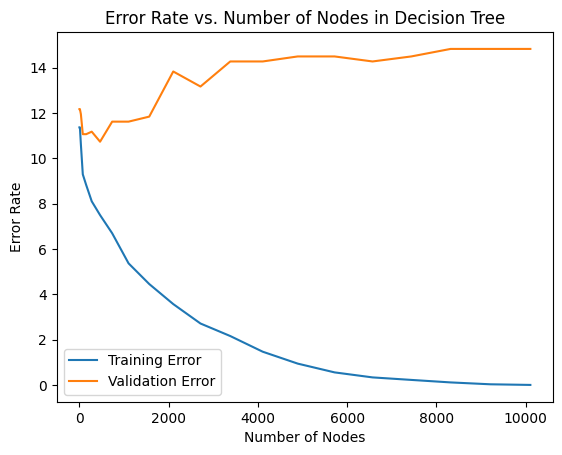

In [19]:
import matplotlib.pyplot as plt
plt.plot(num_nodes_list, training_errors, label='Training Error')
plt.plot(num_nodes_list, validation_errors, label='Validation Error')
plt.xlabel('Number of Nodes')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Nodes in Decision Tree')
plt.legend()
plt.show()